In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import re
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from sklearn.metrics import f1_score
from wordcloud import WordCloud

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

input_paths = []

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        input_paths.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phishing-email-dataset/SpamAssasin.csv
/kaggle/input/phishing-email-dataset/Nazario.csv
/kaggle/input/phishing-email-dataset/Nigerian_Fraud.csv
/kaggle/input/phishing-email-dataset/CEAS_08.csv
/kaggle/input/phishing-email-dataset/Enron.csv
/kaggle/input/phishing-email-dataset/Ling.csv
/kaggle/input/phishing-email-dataset/phishing_email.csv


After Previewing the data, some datasets set would be dropped as it misses some columns that may be important and can't be derived

In [2]:
input_paths.remove("/kaggle/input/phishing-email-dataset/phishing_email.csv")
input_paths.remove("/kaggle/input/phishing-email-dataset/Enron.csv")
input_paths.remove("/kaggle/input/phishing-email-dataset/Ling.csv")

In [3]:
dataframes = []
for path in input_paths:
    df = pd.read_csv(path)
    dataframes.append(df)

df = pd.concat(dataframes, axis=0, ignore_index=True)
df = df.dropna(subset=['body'])
df.reset_index(drop=True, inplace=True)
df

,sender,receiver,date,subject,body,label,urls
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1
...,...,...,...,...,...,...,...
49854,CNN Alerts <charlene-detecton@btcmarketing.com>,email1007@gvc.ceas-challenge.cc,"Fri, 08 Aug 2008 10:34:50 -0400",CNN Alerts: My Custom Alert,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...,1,0
49855,CNN Alerts <idgetily1971@careplusnj.org>,email104@gvc.ceas-challenge.cc,"Fri, 08 Aug 2008 10:35:11 -0400",CNN Alerts: My Custom Alert,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...,1,0
49856,Abhijit Vyas <xpojhbz@gmail.com>,fxgmqwjn@triptracker.net,"Fri, 08 Aug 2008 22:00:43 +0800",Slideshow viewer,Hello there ! \nGreat work on the slide show v...,0,0
49857,Joseph Brennan <vupzesm@columbia.edu>,zqoqi@spamassassin.apache.org,"Fri, 08 Aug 2008 09:00:46 -0500",Note on 2-digit years,"\nMail from sender , coming from intuit.com\ns...",0,0


In [4]:
df.describe(include=["object"])

,sender,receiver,date,subject,body
count,49528,47767,49376,49772,49859
unique,31414,6510,48621,23559,49857
top,qydlqcws-iacfym@issues.apache.org,user6@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 21:38:18 -0100",CNN.com Daily Top 10,\n\n
freq,462,1375,8,2930,3


In [5]:
df.describe()

,label,urls
count,49859.000000,49859.000000
mean,0.570729,0.678012
std,0.494977,0.467243
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49859 entries, 0 to 49858
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    49528 non-null  object
 1   receiver  47767 non-null  object
 2   date      49376 non-null  object
 3   subject   49772 non-null  object
 4   body      49859 non-null  object
 5   label     49859 non-null  int64 
 6   urls      49859 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.7+ MB


<Axes: >

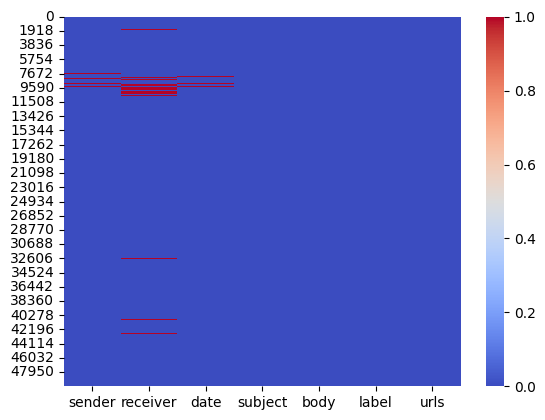

In [7]:
sns.heatmap(df.isnull(), cmap="coolwarm")

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("label", axis=1), df["label"], random_state=42)

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37394 entries, 1441 to 15795
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    37151 non-null  object
 1   receiver  35841 non-null  object
 2   date      37043 non-null  object
 3   subject   37334 non-null  object
 4   body      37394 non-null  object
 5   urls      37394 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.0+ MB


# Percentage of Missing Data 

In [10]:
(X_train.isnull().sum()/len(df)) * 100

sender      0.487374
receiver    3.114784
date        0.703985
subject     0.120339
body        0.000000
urls        0.000000
dtype: float64

<Axes: >

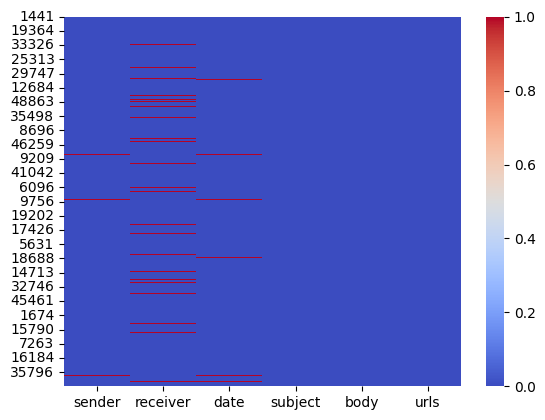

In [11]:
sns.heatmap(X_train.isnull(), cmap="coolwarm")

In [12]:
X_train.describe(include=["object"])

,sender,receiver,date,subject,body
count,37151,35841,37043,37334,37394
unique,24274,5437,36593,18654,37393
top,qydlqcws-iacfym@issues.apache.org,user6@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 21:38:18 -0100",CNN.com Daily Top 10,\n\n
freq,336,1049,5,2216,2


In [13]:
phishing_emails = X_train[y_train == 1]
non_phishing_emails = X_train[y_train == 0]

In [14]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

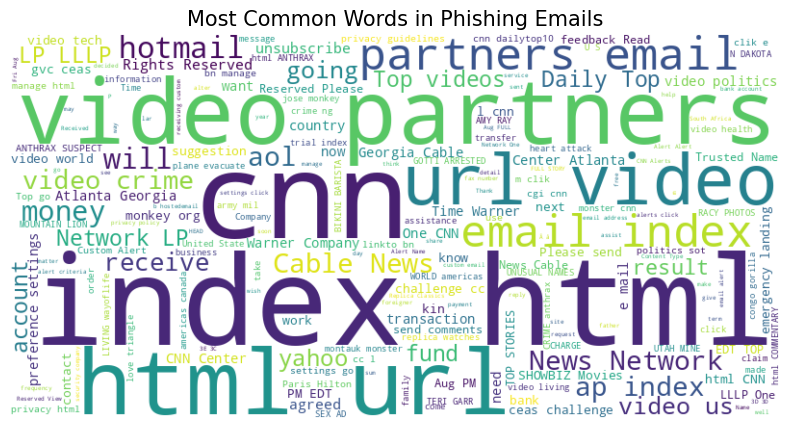

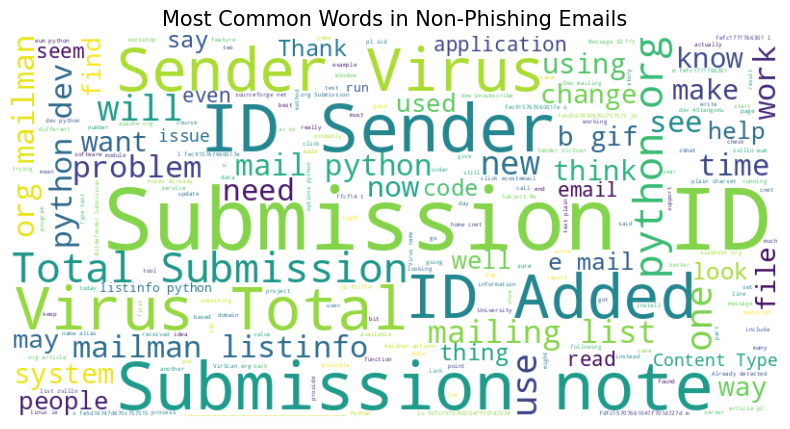

In [15]:
plot_wordcloud(phishing_emails["body"], "Most Common Words in Phishing Emails")
plot_wordcloud(non_phishing_emails["body"], "Most Common Words in Non-Phishing Emails")


# Handling of missing data

1. Body: remove any rows with body na, for future dataset

set other values with unknown and adds new column indicating if it was unkown

In [16]:
class DropNaBodyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="body"):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Ensure it's a DataFrame for easy manipulation
        if isinstance(X, pd.DataFrame):
            return X.dropna(subset=[self.column])
        else:
            raise ValueError("Input must be a pandas DataFrame")

In [17]:
drop_na_imputer = DropNaBodyTransformer()

X_imputed = drop_na_imputer.fit_transform(X_train)
X_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37394 entries, 1441 to 15795
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    37151 non-null  object
 1   receiver  35841 non-null  object
 2   date      37043 non-null  object
 3   subject   37334 non-null  object
 4   body      37394 non-null  object
 5   urls      37394 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.0+ MB


In [18]:
class MissingValueIndicatorFiller(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value="unknown"):
        self.fill_value = fill_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Transform the data by filling missing values and adding indicator columns.

        Args:
            X: Input data (Pandas DataFrame).

        Returns:
            Transformed DataFrame.
        """
        X = X.copy()
        
        for feature in X.columns:
            # Create the indicator column
            indicator_col = f"{feature}_is_known"
            X[indicator_col] = X[feature].notna().astype(int)  # 1 if known, 0 if unknown
            
            # Fill missing values
            X[feature] = X[feature].fillna(self.fill_value)
        
        return X

In [19]:
imputer = MissingValueIndicatorFiller()


X_imputed = imputer.fit_transform(X_train[["sender", "date", "subject"]])
X_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37394 entries, 1441 to 15795
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   sender            37394 non-null  object
 1   date              37394 non-null  object
 2   subject           37394 non-null  object
 3   sender_is_known   37394 non-null  int64 
 4   date_is_known     37394 non-null  int64 
 5   subject_is_known  37394 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.0+ MB


In [20]:
class URLImputer(BaseEstimator, TransformerMixin):
    def __init__(self, url_regex=None):
        self.url_regex = url_regex
        if self.url_regex is None:
            self.url_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
        self.url_finder = re.compile(self.url_regex)
        
    def fit(self, X, y=None):
        return self

    def _identify_url(self, row):
        if pd.isna(row['urls']):
            body = str(row['body'])
            is_url = bool(self.url_finder.search(body))
            return int(is_url)
        else:
            return row['urls']

    def transform(self, X, y=None):
        impute_X = X.copy()
        impute_X['urls'] = X.apply(self._identify_url, axis=1)
        # impute_X.drop("body", inplace=True, axis=1)

        return impute_X
    

In [21]:
X_test_url_imput = X_train.copy()
X_test_url_imput['old_urls'] = X_test_url_imput['urls']
X_test_url_imput['urls'] = X_test_url_imput['old_urls'].apply(lambda x: pd.NA)
X_test_url_imput.info()

imputer = URLImputer()
X_imputed = imputer.fit_transform(X_test_url_imput)
X_imputed.info()

f1_score(X_imputed['old_urls'], X_imputed['urls'])

<class 'pandas.core.frame.DataFrame'>
Index: 37394 entries, 1441 to 15795
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    37151 non-null  object
 1   receiver  35841 non-null  object
 2   date      37043 non-null  object
 3   subject   37334 non-null  object
 4   body      37394 non-null  object
 5   urls      0 non-null      object
 6   old_urls  37394 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 37394 entries, 1441 to 15795
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    37151 non-null  object
 1   receiver  35841 non-null  object
 2   date      37043 non-null  object
 3   subject   37334 non-null  object
 4   body      37394 non-null  object
 5   urls      37394 non-null  int64 
 6   old_urls  37394 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.3+ MB


0.9722312307442842

The URL Imputer seems to do very well with an f1 score of 97 %

In [22]:
data_preprocessing = ColumnTransformer([
    ("fill_na", MissingValueIndicatorFiller(), ["subject", "sender", "date"]),
    ("url", URLImputer(), ["urls", "body"])
])

datapreprocessing_pipeline = Pipeline([
    # ("drop_body_na", DropNaBodyTransformer()),
    ("handleNA", data_preprocessing)
])

processed_data = datapreprocessing_pipeline.fit_transform(X_train)
processed_data[0]

array(['Re: [SAtalk] redhat init.d script for spamd and the -H option',
       'Theo Van Dinter <felicity@kluge.net>',
       'Fri, 6 Sep 2002 13:54:11 -0400', 1, 1, 1, 1,
       '--UHN/qo2QbUvPLonB\nContent-Type: text/plain; charset=us-ascii\nContent-Disposition: inline\nContent-Transfer-Encoding: quoted-printable\n\nOn Fri, Sep 06, 2002 at 11:32:01AM -0500, Josh Hildebrand wrote:\n> Unfortunately, when I run that, it complains about the H parameter.\n>=20\n>   -F 0|1          remove/add \'From \' line at start of output (default: 1)\n>=20\n> But I can run it on the command line as "spamd -d -c -a -H" just fine.\n>=20\n> Anyone else run into this problem?\n\nyou look to have 2 versions of spamd installed.  The one running from\nthe RC script is pre-2.4 (there is a -H now, and -F has been removed),\nbut the one you run from the commandline seems to be a 2.4x version.\n\nI would find that old version of SA and blow it away.\n\n--=20\nRandomly Generated Tagline:\n"If you lend someone $20

In [23]:
processed_data[0, [0,1,7]]

array(['Re: [SAtalk] redhat init.d script for spamd and the -H option',
       'Theo Van Dinter <felicity@kluge.net>',
       '--UHN/qo2QbUvPLonB\nContent-Type: text/plain; charset=us-ascii\nContent-Disposition: inline\nContent-Transfer-Encoding: quoted-printable\n\nOn Fri, Sep 06, 2002 at 11:32:01AM -0500, Josh Hildebrand wrote:\n> Unfortunately, when I run that, it complains about the H parameter.\n>=20\n>   -F 0|1          remove/add \'From \' line at start of output (default: 1)\n>=20\n> But I can run it on the command line as "spamd -d -c -a -H" just fine.\n>=20\n> Anyone else run into this problem?\n\nyou look to have 2 versions of spamd installed.  The one running from\nthe RC script is pre-2.4 (there is a -H now, and -F has been removed),\nbut the one you run from the commandline seems to be a 2.4x version.\n\nI would find that old version of SA and blow it away.\n\n--=20\nRandomly Generated Tagline:\n"If you lend someone $20, and never see that person again, it was probably\n 

In [24]:
import numpy as np
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin

class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, placeholder="unknown", date_format="%a, %d %b %Y %H:%M:%S %z"):
        self.placeholder = placeholder
        self.date_format = date_format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # X is assumed to be a NumPy array (with columns: 'subject', 'sender', 'date', 'body', 'urls')
        
        # Extract the 'date' column (index of 'date' can vary, here it's assumed to be index 2)
        date_column_idx = 0
        date_column = X[:, date_column_idx]

        # Handle missing or placeholder values
        parsed_dates = np.vectorize(self._safe_parse_date)(date_column)

        # Extract features from parsed dates
        day_of_week = np.vectorize(lambda x: x.weekday() if x else 0)(parsed_dates)
        hour_of_day = np.vectorize(lambda x: x.hour if x else 0)(parsed_dates)
        is_weekend = (day_of_week >= 5).astype(int)  # 1 for weekend, 0 for weekday
        year = np.vectorize(lambda x: x.year if x else 1900)(parsed_dates)
        month = np.vectorize(lambda x: x.month if x else 1)(parsed_dates)
        day_of_month = np.vectorize(lambda x: x.day if x else 1)(parsed_dates)

        # Stack all new features together as columns (along with the rest of the data)
        X_new = np.column_stack([day_of_week, hour_of_day, is_weekend, year, month, day_of_month])
        
        # Return the transformed data (now with additional features)
        return X_new

    def _safe_parse_date(self, date_str):
        try:
            return datetime.strptime(date_str, self.date_format)
        except (ValueError, TypeError):
            return None  # Return None for invalid dates



In [25]:
date_imputer = DateFeatureExtractor()

X_imputed = date_imputer.fit_transform(X_train[["date"]].values)
X_imputed

array([[   4,   13,    0, 2002,    9,    6],
       [   2,   20,    0, 2008,    8,    6],
       [   2,    9,    0, 2008,    8,    6],
       ...,
       [   3,   11,    0, 2008,    8,    7],
       [   0,    0,    0, 1900,    1,    1],
       [   1,   19,    0, 2008,    8,    5]])

In [26]:
feature_extraction_pipeline = ColumnTransformer([
    ("subject_tfidf", TfidfVectorizer(), 0),  # Column index for 'subject'

    ("sender_tfidf", TfidfVectorizer(), 1),  # Column index for 'sender'

    ("body_tfidf", TfidfVectorizer(), 2)  # Column index for 'body'
], remainder="passthrough")  # Keep other columns unchanged

feature_extraction_pipeline = ColumnTransformer([
    ("date_extraction", DateFeatureExtractor(), [2]),
    ("text_extraction", feature_extraction_pipeline, [0, 1, 7])
], remainder='passthrough')


full_pipeline = Pipeline([
    ("preprocessing", datapreprocessing_pipeline),
    ("feature_extraction", feature_extraction_pipeline)
])

clean_data = full_pipeline.fit_transform(X_train)
clean_data.shape

(37394, 451378)

In [27]:
rfc_model = RandomForestClassifier(random_state=42)
scores = cross_val_score(rfc_model, clean_data, y_train, cv=3, scoring='f1')
print(f"Random Forest Score {scores.mean()}")

Random Forest Score 0.9864026734288149


In [28]:
xgd_model = XGBClassifier(random_state=42)
scores = cross_val_score(xgd_model, clean_data, y_train, cv=3, scoring='f1')
print(f"XGD Boost Score {scores.mean()}")

XGD Boost Score 0.9931600024833974


In [29]:
xgd_model.fit(clean_data, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
clean_test = full_pipeline.transform(X_test)
test_pred = xgd_model.predict(clean_test)
f1_score(test_pred, y_test)

0.9903791737408036